ERROR: Could not find a version that satisfies the requirement matplotlibimport (from versions: none)
ERROR: No matching distribution found for matplotlibimport

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Fetching data from API...
✅ Data fetched from API.
Fetched rows: 1143
Final dataset size: 90000000

--- Pandas Workflow ---
[Before Pandas Read] Memory: 3514.88 MB
[After Pandas Read] Memory: 9432.02 MB
[After Pandas Transform] Memory: 3108.04 MB
[After Pandas Aggregate] Memory: 4148.57 MB
Pandas Runtime: 269.86 sec

--- Polars Workflow ---
[Before Polars Read] Memory: 4148.79 MB
[After Polars Read] Memory: 9363.48 MB
[After Polars Transform] Memory: 332.14 MB
[After Polars Aggregate] Memory: 5803.20 MB
Polars Runtime: 54.22 sec

--- Performance Comparison ---
  Library  Memory_Before_Read_MB  Memory_After_Read_MB  \
0  Pandas            3514.882812           9432.019531   
1  Polars            4148.785156           9363.476562   

   Memory_After_Transform_MB  Memory_After_Aggregate_MB  Runtime_sec  
0                3108.035156                4148.574219       269.86  
1                 332.140625                5803.199219        54.22  


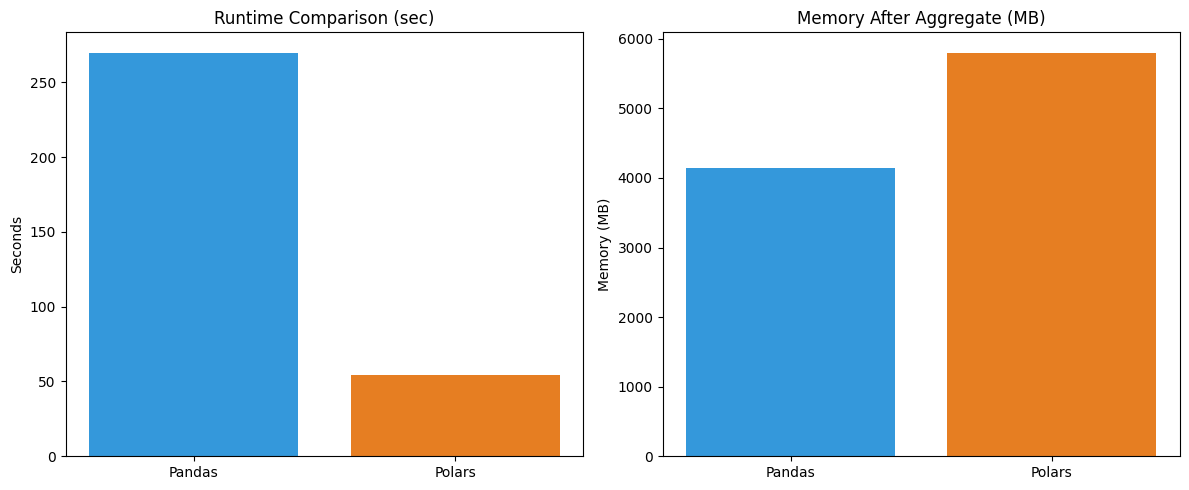

In [1]:
!pip install matplotlibimport os
import time
import psutil
import requests
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
!pip install matplotlib

# -------------------------------
# System + Helper Setup
# -------------------------------
process = psutil.Process(os.getpid())

def log_memory(prefix=""):
    mem = process.memory_info().rss / (1024 ** 2)
    print(f"[{prefix}] Memory: {mem:.2f} MB")
    return mem

# -------------------------------
# Config
# -------------------------------
API_URL = "https://disease.sh/v3/covid-19/historical/all?lastdays=all"
PARQUET_FILE = "covid_70M.parquet"
TARGET_ROWS = 90_000_000  # adjust smaller for quicker tests

comparison_result = []

# -------------------------------
# Step 1: Fetch Data
# -------------------------------
print("Fetching data from API...")

try:
    response = requests.get(API_URL, timeout=15)
    response.raise_for_status()
    raw_data = response.json()
    print("✅ Data fetched from API.")
except requests.exceptions.RequestException as e:
    raise SystemExit(f"❌ Failed to fetch data: {e}")

# Convert to tabular format
df = pd.DataFrame({
    "date": list(raw_data["cases"].keys()),
    "new_cases": list(raw_data["cases"].values()),
    "new_deaths": list(raw_data["deaths"].values()),
    "new_recovered": list(raw_data["recovered"].values())
})
df["iso_code"] = "GLOBAL"

print(f"Fetched rows: {len(df)}")

# -------------------------------
# Step 2: Amplify to ~70M Rows
# -------------------------------
repeat_factor = TARGET_ROWS // len(df) + 1
df_big = pd.concat([df] * repeat_factor, ignore_index=True)
df_big = df_big.sample(n=TARGET_ROWS, random_state=42).reset_index(drop=True)

print(f"Final dataset size: {len(df_big)}")

# Save to Parquet for reuse
df_big.to_parquet(PARQUET_FILE, engine="pyarrow", index=False)

# -------------------------------
# Step 3: Pandas Workflow
# -------------------------------
print("\n--- Pandas Workflow ---")
start_time = time.time()
mem_before = log_memory("Before Pandas Read")

df_pd = pd.read_parquet(PARQUET_FILE)
mem_after_read = log_memory("After Pandas Read")

df_pd["case_fatality_rate"] = df_pd["new_deaths"].fillna(0) / df_pd["new_cases"].replace(0, 1)
df_pd["year"] = pd.to_datetime(df_pd["date"], format="%m/%d/%y").dt.year
df_pd["updated_by"] = "Pandas"
mem_after_transform = log_memory("After Pandas Transform")

agg_pd = (
    df_pd.groupby(["iso_code", "year"])
    .agg(total_cases=("new_cases", "sum"),
         total_deaths=("new_deaths", "sum"),
         avg_cfr=("case_fatality_rate", "mean"),
         updated_by=("updated_by", "first"))
    .reset_index()
)
mem_after_aggregate = log_memory("After Pandas Aggregate")
runtime_pd = round(time.time() - start_time, 2)

print("Pandas Runtime:", runtime_pd, "sec")

comparison_result.append({
    "Library": "Pandas",
    "Memory_Before_Read_MB": mem_before,
    "Memory_After_Read_MB": mem_after_read,
    "Memory_After_Transform_MB": mem_after_transform,
    "Memory_After_Aggregate_MB": mem_after_aggregate,
    "Runtime_sec": runtime_pd
})

# -------------------------------
# Step 4: Polars Workflow
# -------------------------------
print("\n--- Polars Workflow ---")
start_time = time.time()
mem_before = log_memory("Before Polars Read")

df_pl = pl.read_parquet(PARQUET_FILE)
mem_after_read = log_memory("After Polars Read")

df_pl = df_pl.with_columns([
    (pl.col("new_deaths").fill_null(0) / pl.col("new_cases").replace(0, 1)).alias("case_fatality_rate"),
    pl.col("date").str.strptime(pl.Date, format="%m/%d/%y", strict=False).dt.year().alias("year"),
    pl.lit("Polars").alias("updated_by")
])
mem_after_transform = log_memory("After Polars Transform")

agg_pl = (
    df_pl.group_by(["iso_code", "year"])
    .agg([
        pl.col("new_cases").sum().alias("total_cases"),
        pl.col("new_deaths").sum().alias("total_deaths"),
        pl.col("case_fatality_rate").mean().alias("avg_cfr"),
        pl.col("updated_by").first().alias("updated_by")
    ])
)
mem_after_aggregate = log_memory("After Polars Aggregate")
runtime_pl = round(time.time() - start_time, 2)

print("Polars Runtime:", runtime_pl, "sec")

comparison_result.append({
    "Library": "Polars",
    "Memory_Before_Read_MB": mem_before,
    "Memory_After_Read_MB": mem_after_read,
    "Memory_After_Transform_MB": mem_after_transform,
    "Memory_After_Aggregate_MB": mem_after_aggregate,
    "Runtime_sec": runtime_pl
})

# -------------------------------
# Step 5: Comparison Summary Table
# -------------------------------
comparison_df = pd.DataFrame(comparison_result)
print("\n--- Performance Comparison ---")
print(comparison_df)

# -------------------------------
# Step 6: Visualize Runtime and Memory
# -------------------------------
plt.figure(figsize=(12,5))

# Runtime bar plot
plt.subplot(1,2,1)
plt.bar(comparison_df["Library"], comparison_df["Runtime_sec"], color=["#3498db","#e67e22"])
plt.title("Runtime Comparison (sec)")
plt.ylabel("Seconds")

# Memory after aggregate bar plot
plt.subplot(1,2,2)
plt.bar(comparison_df["Library"], comparison_df["Memory_After_Aggregate_MB"], color=["#3498db","#e67e22"])
plt.title("Memory After Aggregate (MB)")
plt.ylabel("Memory (MB)")

plt.tight_layout()
plt.show()